In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm

c:\Users\jigna\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


\begin{align}
\partial_x u_{\theta} &= cos(x)\\
u_{\theta}(0) &= 0\\
u_{\theta}(2\pi) &= 0.
\end{align}


In [312]:



class MyModel(tf.Module):
    # One hidden layer model: 2w + 2b
    def __init__(self, n_units, **kwargs):
        super().__init__(**kwargs)


        # Initialize weight and bias as trainable tf.Variables
        w1 = np.random.uniform(0, 1, size=(n_units,1))
        w1 = tf.Variable(w1, trainable=True, name='w1')
        
        b1 = np.random.uniform(0, 2*np.pi, size=(n_units,1)) * 0
        b1 = tf.Variable(b1, trainable=True, name='b1')
        
        w2 = np.random.uniform(0, 1, size=(n_units,1))
        w2 = tf.Variable(w2, trainable=True, name='w2')

        b2 = np.random.uniform(0, 2*np.pi, size=(1,1))
        #b2 = tf.Variable(b2, trainable=True, name='b2')
        
        self.W = [w1, b1, w2]

        # Learning rate
        self.rate = 0.1
    
    def __call__(self, x):
        # x is going to be a tf.Variable, we need to compute the gradient.
        x = x[0,0].numpy()
        return sum(tf.nn.tanh(self.W[0] * x + self.W[1]) * self.W[2]) + self.W[3]
    
    def evaluate(self, x):
        # Computes u(x; theta)
        a = tf.nn.tanh(tf.add(self.W[0] * x, self.W[1]))
        # u = tf.add(tf.matmul(a, self.W[2], transpose_a=True), self.W[3])
        u = tf.matmul(a, self.W[2], transpose_a=True)   
        return u
    
    def rhs(self, x):
        # Right hand side of the PDE.
        # x: tf.Tensor
        return tf.math.cos(x)

    def get_weights(self):
        return self.W
    
    def set_weights(self, new_weights):
        # Setter for the parameters.
        # Shapes must coincide.
        for i in range(len(new_weights)):
            self.W[i].assign(new_weights[i])
        self.get_weights() 


    ##################### LOSS FUNCTIONS ###########################

    def physics_loss(self, data_set):
        # MSE given by the PDE over data_set.
        # Note that, given the form of the NN, when the derivative w.r.t
        # x is taken, dependence on b_2 is lost. 
        
        l = []

        # For each x in data_set computes second derivative at x.
        for x in data_set:
            x = tf.Variable(x, trainable=False)
            with tf.GradientTape() as tape:
                tape.watch(x)
                y = self.evaluate(x)
            u_x = tape.gradient(y, x)
            l.append(tf.subtract(u_x, self.rhs(x)))
            del tape
        loss = tf.math.reduce_mean(tf.math.multiply(l, l))
        return loss

    def boundary_condition(self):
        # PDE boundary condition.
        # output shape : () same as physical_loss()
        a = tf.add(self.evaluate(0)**2, self.evaluate(2 * np.pi)**2)
        return tf.reshape(a, ())

    def total_loss(self, data_set):
        # Loss computed from the PDE + loss from training data.
        return self.physics_loss(data_set) + self.boundary_condition()

    ##################### TRAINING FUNCTIONS ###########################


    def new_weight(self, old_W, gradients):
        # old_W: list of tensors
        # gradients: list of tensors
        # Computes: theta_{k+1} = t_k - \eta\grad L(\theta_k)
        new_W = []
        for w, grad in zip(old_W, gradients):
            aux = w - self.rate * grad
            new_W.append(aux)
        return new_W

    def gradients(self, data_set):
        # Performs one iteration of GD.
        # Since self.trainable_variables is constantly being updated,
        # the gradient is evaluated at different values of weights.
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            target = self.total_loss(data_set)
        gradients = tape.gradient(target, self.trainable_variables)
        return gradients
            
    def update(self, data_set):
        # Performs the update on the weights according to 
        # the gradient descent.
        old_w = self.get_weights()
        gradients = self.gradients(data_set)
        new_W = self.new_weight(old_w, gradients)
        self.set_weights(new_W)
    
    def train(self):
        # Generates a batch at each iteration
        num_iter = 1000
        for _ in tqdm(range(num_iter)):
            data_set = np.random.uniform(0, 2 * np.pi, 64)
            self.update(data_set)
    
    def train_option(self, batches: list):
        for batch in batches:
            for _, x in enumerate(batch):
                #print(f'step {_}')
                with tf.GradientTape() as tape:
                    tape.watch(self.trainable_variables) 
                    target = self.total_loss(x)
                grads = tape.gradient(target, self.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
    ##################################################################
    


In [313]:
#optimizer = keras.optimizers.legacy.SGD(learning_rate=1e-3)
model = MyModel(3)
model.trainable_variables

(<tf.Variable 'w1:0' shape=(3, 1) dtype=float64, numpy=
 array([[0.73439177],
        [0.17972853],
        [0.48988904]])>,
 <tf.Variable 'b1:0' shape=(3, 1) dtype=float64, numpy=
 array([[0.],
        [0.],
        [0.]])>,
 <tf.Variable 'w2:0' shape=(3, 1) dtype=float64, numpy=
 array([[0.5199859 ],
        [0.8902477 ],
        [0.76834593]])>)

In [314]:
model.train()

100%|██████████| 1000/1000 [02:42<00:00,  6.16it/s]


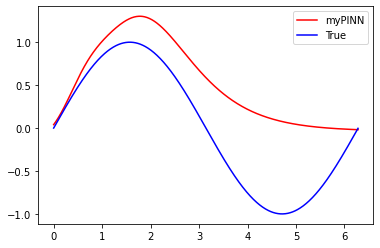

In [315]:
x = np.arange(0, 2 * np.pi, 0.01)
y = [model.evaluate(v)[0,0].numpy() for v in x]
z = [tf.math.sin(v) for v in x]
plt.plot(x, y, color='r', label='myPINN')
plt.plot(x, z, color='b', label='True')
plt.legend()
plt.show()

In [72]:
x = tf.constant(0.0)
tf.math.cos(x)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [65]:
np.pi

3.141592653589793

In [77]:
a = [tf.constant(1), tf.constant(1)]
tf.reduce_sum(a)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [3]:
m = np.random.normal(0,1,(10,10))

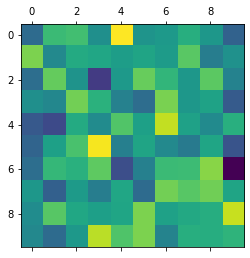

In [4]:
plt.matshow(m)